# Human hematopoiesis dynamics
# Extract biological activities by [decoupler](https://decoupler-py.readthedocs.io)

In [2]:
import scanpy as sc
import decoupler as dc
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
import dynamo as dyn
dyn.dynamo_logger.main_silence()

dyn.get_all_dependencies_version()

2023-12-13 14:13:42.637641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-13 14:13:44.866846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


package    tqdm statsmodels setuptools   scipy scikit-learn pandas   numpy  \
version  4.65.0      0.14.0     68.0.0  1.10.0        1.2.2  1.5.3  1.22.3   

package networkx matplotlib anndata  igraph loompy numdifftools umap-learn  \
version    2.8.4      3.7.1   0.9.1  0.10.4  3.0.7       0.9.41      0.5.3   

package   numba seaborn colorcet pynndescent pre-commit get-version openpyxl  \
version  0.56.4  0.12.2    3.0.1       0.5.8      3.2.0       3.5.4  3.2.0b1   

package typing-extensions session-info dynamo-release  
version             4.5.0        1.0.0          1.3.3

## Load data

In [3]:
adata = anndata.read("hsc_raw_with_metadata.h5ad")

## Preprocess the Data

In [4]:
dyn.pp.recipe_monocle(adata)

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
Error: The requests_cache python module is required to use request caching.
See - https://requests-cache.readthedocs.io/en/latest/user_guide.html#installation
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
que

## Pathway activity inference
### [PROGENy](https://saezlab.github.io/progeny/) model for pathway activity inference
`PROGENy` is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. 

In [5]:
progeny = dc.get_progeny(organism='human', top=500)

In [7]:
adata.raw = adata

### run activity inference with multivariate linear model (MLM)

In [8]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True)

5732 features of mat are empty, they will be removed.
Running mlm on mat with 1947 samples and 15684 targets for 14 sources.


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


In [9]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)

### Visualization

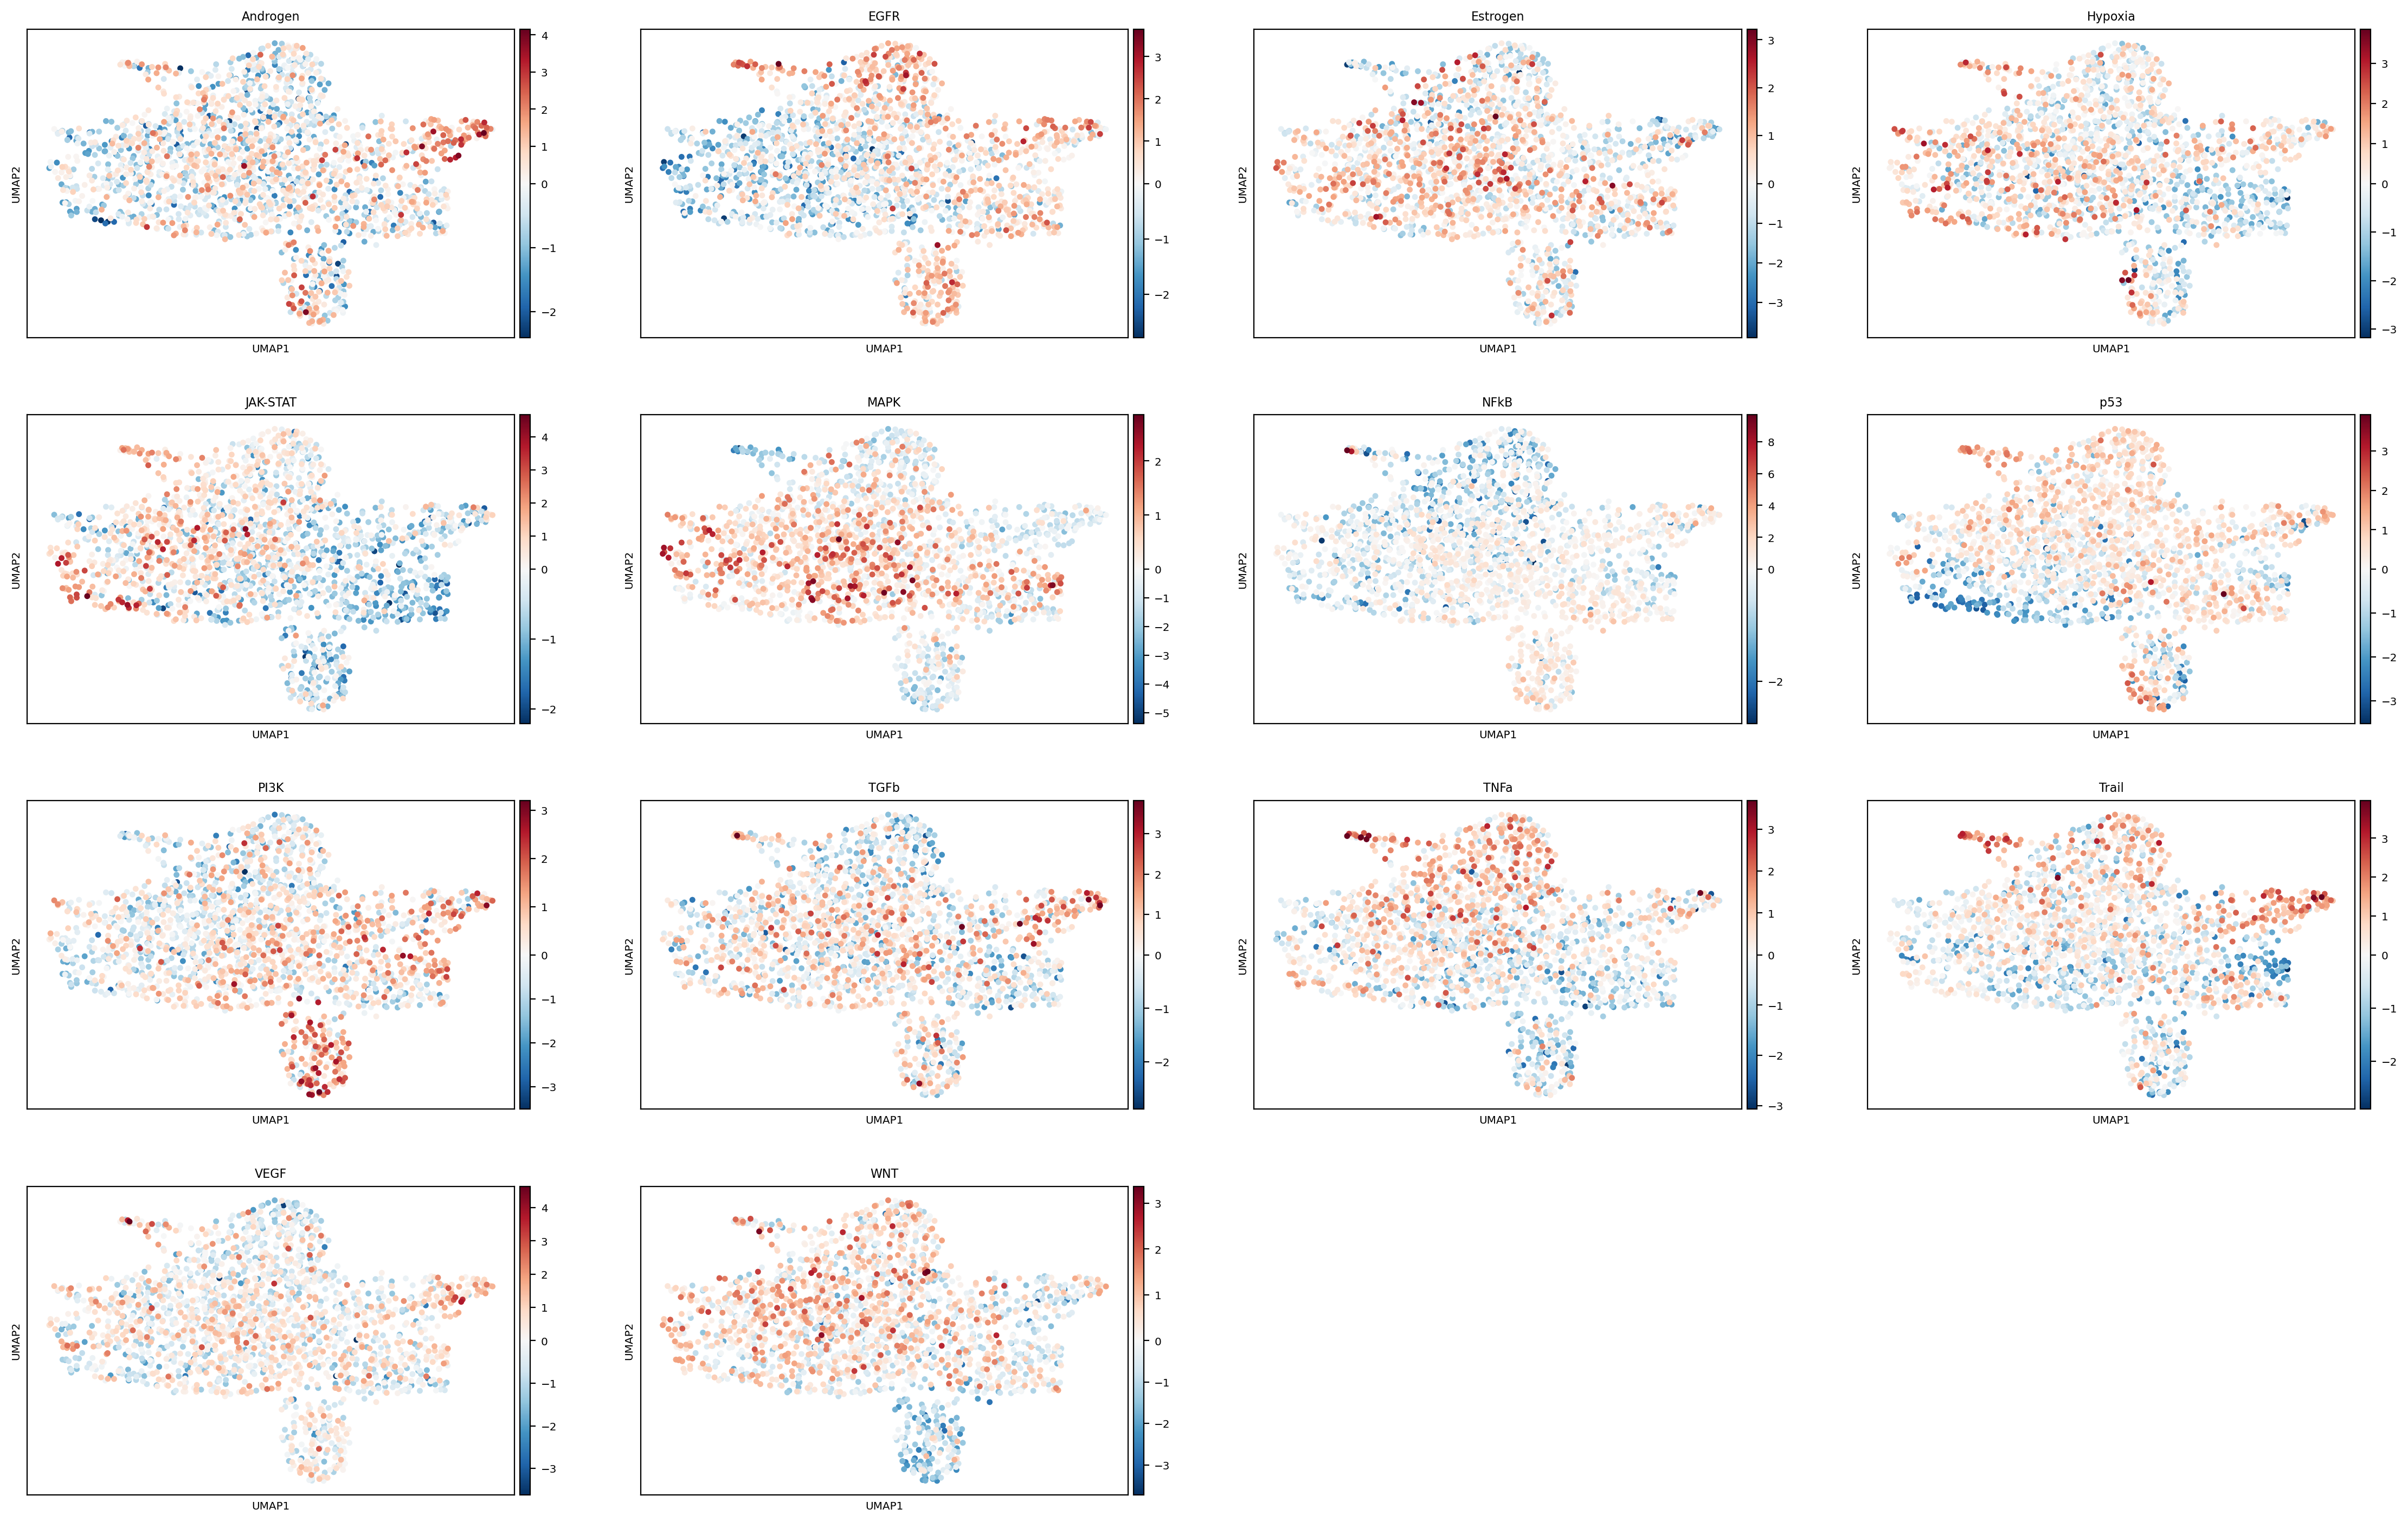

In [10]:
sc.pl.umap(acts, 
           color=['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB', 'p53', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT'], 
           cmap='RdBu_r', 
           vcenter=0)

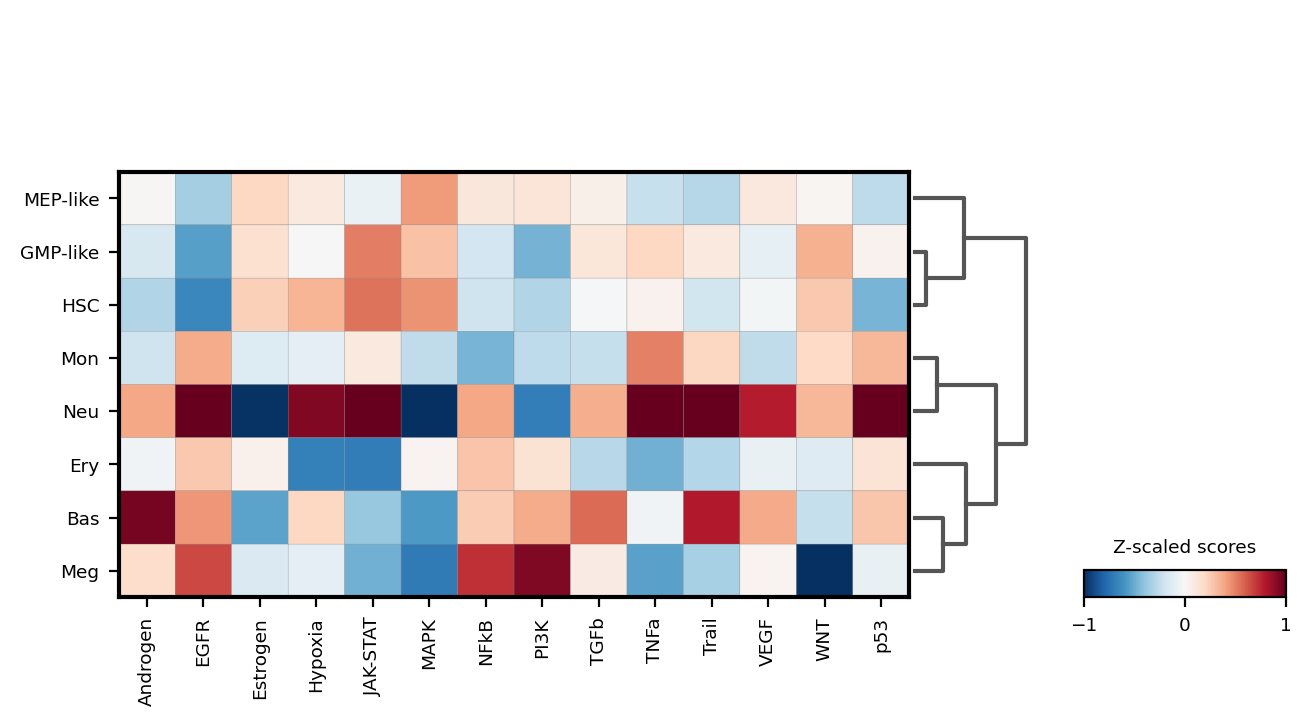

In [11]:
sc.pl.matrixplot(acts, 
                 var_names=acts.var_names, 
                 groupby='cell_type', 
                 dendrogram=True,
                 colorbar_title='Z-scaled scores', 
                 vmin=-1, 
                 vmax=1, 
                 cmap='RdBu_r',)

## Functional enrichment of biological terms
### MSigDB gene sets
The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [12]:
msigdb = dc.get_resource('MSigDB')

In [13]:
# Remove duplicated entries
msigdb_noFilter = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

### Enrichment with Over Representation Analysis (ORA)
run ora with a simple one-liner:

In [14]:
dc.run_ora(
    mat=adata,
    net=msigdb_noFilter,
    source='geneset',
    target='genesymbol',
    verbose=True)

5732 features of mat are empty, they will be removed.
Running ora on mat with 1947 samples and 15684 targets for 30800 sources.


100%|███████████████████████████████████████████████████████████| 1947/1947 [01:15<00:00, 25.85it/s]


### Visualization

In [15]:
noFilter_Functional_acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
noFilter_Functional_acts_v = noFilter_Functional_acts.X.ravel()
max_e = np.nanmax(noFilter_Functional_acts_v[np.isfinite(noFilter_Functional_acts_v)])
noFilter_Functional_acts.X[~np.isfinite(noFilter_Functional_acts.X)] = max_e

# We can scale the obtained activities for better visualizations
sc.pp.scale(noFilter_Functional_acts)
noFilter_Functional_acts

AnnData object with n_obs × n_vars = 1947 × 30800
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'mean', 'std'
    uns: 'genes_to_use', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'dendrogram_cell_type'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'mlm_estimate', 'mlm_pvals', 'ora_estimate', 'ora_pvals'

In [16]:
noFilter_df = dc.rank_sources_groups(noFilter_Functional_acts, groupby='cell_type', reference='rest', method='t-test_overestim_var')
noFilter_df

group reference                                              names  \
0        Bas      rest                 HAY_BONE_MARROW_CD34_POS_EO_B_MAST   
1        Bas      rest                  CUI_DEVELOPING_HEART_C7_MAST_CELL   
2        Bas      rest  ZHENG_CORD_BLOOD_C2_PUTATIVE_BASOPHIL_EOSINOPH...   
3        Bas      rest               TRAVAGLINI_LUNG_BASOPHIL_MAST_1_CELL   
4        Bas      rest  DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_MAST_C...   
...      ...       ...                                                ...   
246395   Neu      rest             KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP   
246396   Neu      rest                   DODD_NASOPHARYNGEAL_CARCINOMA_DN   
246397   Neu      rest                             FEVR_CTNNB1_TARGETS_DN   
246398   Neu      rest                           PUJANA_CHEK2_PCC_NETWORK   
246399   Neu      rest                    CAIRO_HEPATOBLASTOMA_CLASSES_UP   

        statistic  meanchange         pvals     pvals_adj  
0       17.059972    2.526386  3.535777e-40  5.692746e-36  
1       15.528721    2.162962  4.141365e-37  4.251801e-33  
2       15.262481    1.618901  3.696588e-40  5.692746e-36  
3       15.219242    2.149443  4.965191e-36  3.823197e-32  
4       14.752779    2.372553  3.302256e-33  2.034190e-29  
...           ...         ...           ...           ...  
246395  -9.027305   -1.691898  2.827477e-11  4.376195e-09  
246396  -9.805175   -1.849021  1.874443e-12  5.064284e-10  
246397  -9.834977   -1.855294  1.680749e-12  4.622059e-10  
246398 -11.045579   -2.627860  2.795363e-16  4.531431e-13  
246399 -11.430277   -2.323190  5.346501e-16  7.205384e-13  

[246400 rows x 7 columns]

In [17]:
n_markers = 4
noFilter_source_markers = noFilter_df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
noFilter_source_markers

{'Bas': ['HAY_BONE_MARROW_CD34_POS_EO_B_MAST',
  'CUI_DEVELOPING_HEART_C7_MAST_CELL',
  'ZHENG_CORD_BLOOD_C2_PUTATIVE_BASOPHIL_EOSINOPHIL_MAST_CELL_PROGENITOR',
  'TRAVAGLINI_LUNG_BASOPHIL_MAST_1_CELL'],
 'Ery': ['GNF2_PRDX2',
  'GOBP_GAS_TRANSPORT',
  'GOBP_CARBON_DIOXIDE_TRANSPORT',
  'HU_FETAL_RETINA_BLOOD'],
 'GMP-like': ['HAY_BONE_MARROW_CD34_POS_HSC',
  'ZAK_PBMC_MRKAD5_HIV_1_GAG_POL_NEF_AGE_20_50YO_1DY_DN',
  'OSMAN_BLOOD_CHAD63_KH_AGE_18_50YO_HIGH_DOSE_SUBJECTS_24HR_DN',
  'JAATINEN_HEMATOPOIETIC_STEM_CELL_UP'],
 'HSC': ['ERWIN_COHEN_BLOOD_LIVE_VACCINE_TC_83_AGE_23_48YO_VACCINATED_VS_CONTROL_14DY_UP',
  'ZAK_PBMC_MRKAD5_HIV_1_GAG_POL_NEF_AGE_20_50YO_1DY_DN',
  'HAMAI_APOPTOSIS_VIA_TRAIL_UP',
  'MENON_FETAL_KIDNEY_0_CAP_MESENCHYME_CELLS'],
 'MEP-like': ['RODRIGUES_THYROID_CARCINOMA_POORLY_DIFFERENTIATED_UP',
  'MILI_PSEUDOPODIA_HAPTOTAXIS_UP',
  'KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP',
  'RODRIGUES_THYROID_CARCINOMA_ANAPLASTIC_UP'],
 'Meg': ['TRAVAGLINI_LUNG_PLATELET_MEGAKARYOC

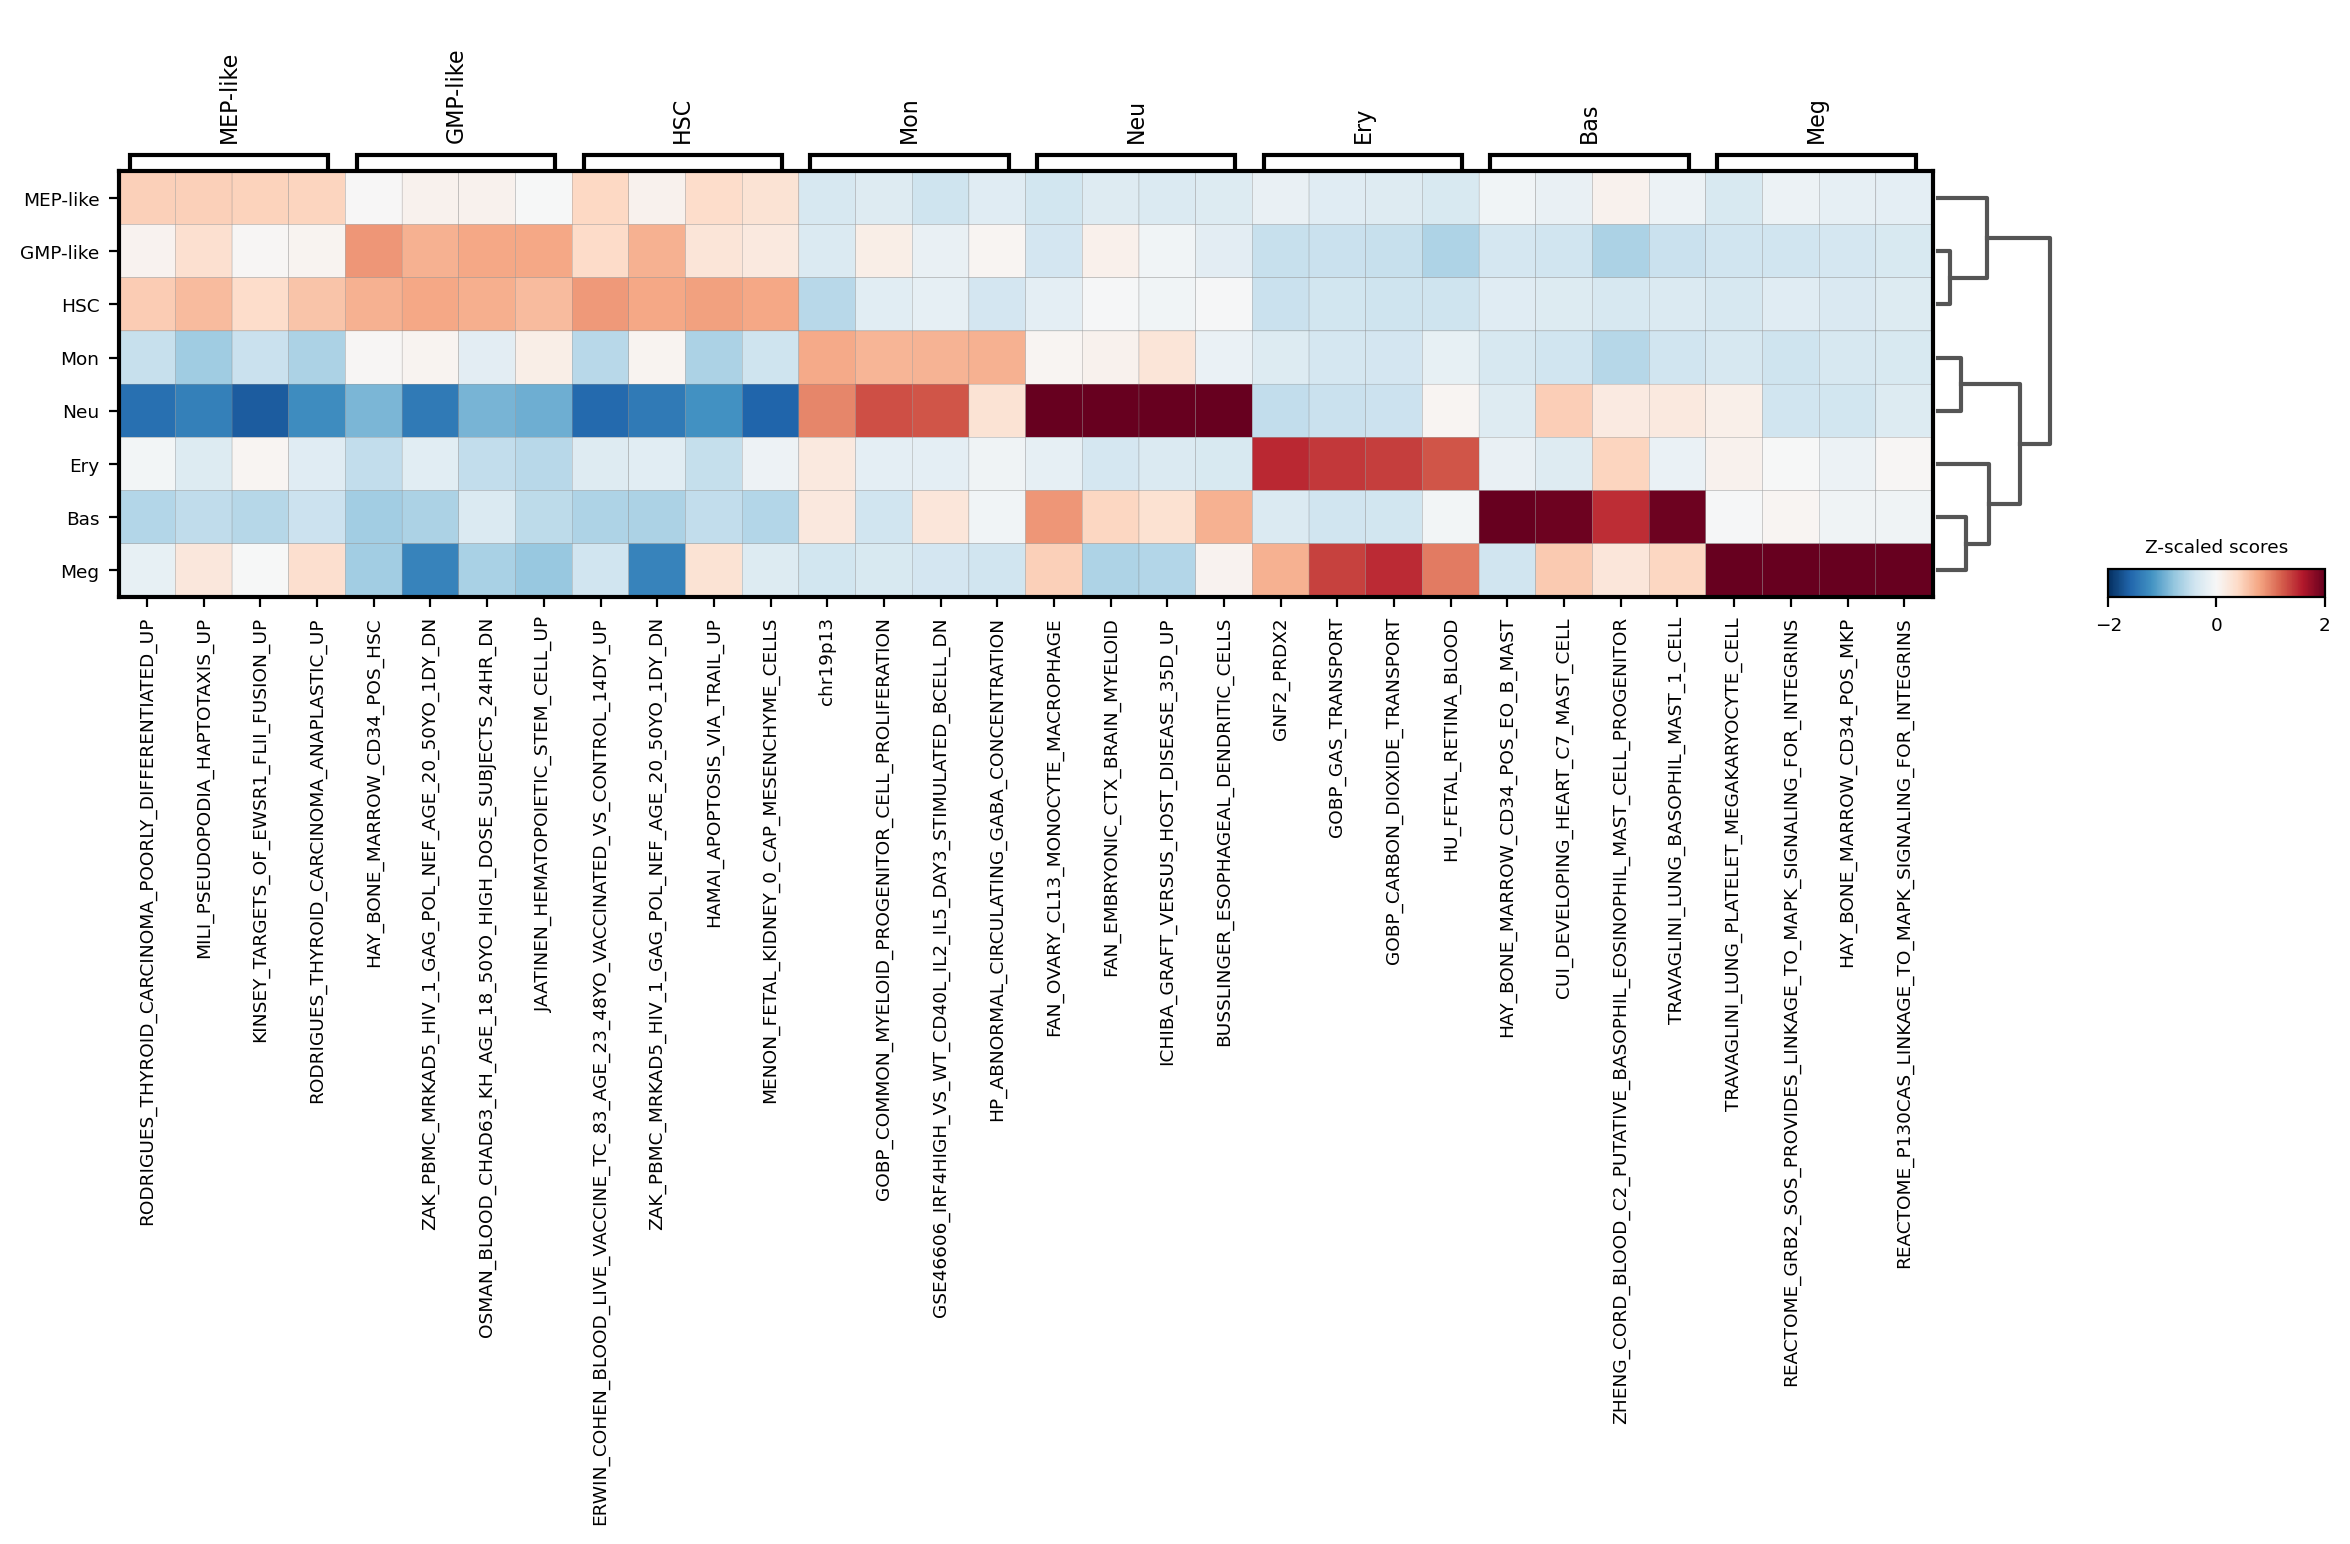

In [18]:
sc.pl.matrixplot(noFilter_Functional_acts, 
                 noFilter_source_markers, 
                 'cell_type', 
                 dendrogram=True,
                 colorbar_title='Z-scaled scores', 
                 vmin=-2, 
                 vmax=2, 
                 cmap='RdBu_r',)

In [19]:
noFilter_source_markers1={
 'Bas': ['HAY_BONE_MARROW_CD34_POS_EO_B_MAST',
  'CUI_DEVELOPING_HEART_C7_MAST_CELL',
  'TRAVAGLINI_LUNG_BASOPHIL_MAST_1_CELL',
  'ZHENG_CORD_BLOOD_C2_PUTATIVE_BASOPHIL_EOSINOPHIL_MAST_CELL_PROGENITOR'],
 'Ery': ['GNF2_PRDX2',
  'GOBP_GAS_TRANSPORT',
  'GOBP_CARBON_DIOXIDE_TRANSPORT',
  'GOBP_OXYGEN_TRANSPORT'],
 'GMP-like': ['HAY_BONE_MARROW_CD34_POS_HSC',
  'ZAK_PBMC_MRKAD5_HIV_1_GAG_POL_NEF_AGE_20_50YO_1DY_DN',
  'JAATINEN_HEMATOPOIETIC_STEM_CELL_UP',
  'GRAHAM_CML_QUIESCENT_VS_NORMAL_QUIESCENT_DN'],
 'HSC': ['ERWIN_COHEN_BLOOD_LIVE_VACCINE_TC_83_AGE_23_48YO_VACCINATED_VS_CONTROL_14DY_UP',
  'ZAK_PBMC_MRKAD5_HIV_1_GAG_POL_NEF_AGE_20_50YO_1DY_DN',
  'MENON_FETAL_KIDNEY_0_CAP_MESENCHYME_CELLS',
  'NAKAYA_PBMC_FLUARIX_FLUVIRIN_AGE_18_50YO_CORRELATED_WITH_HAI_28DY_RESPONSE_AT_7DY_NEGATIVE'],
 'MEP-like': ['RODRIGUES_THYROID_CARCINOMA_POORLY_DIFFERENTIATED_UP',
  'KINSEY_TARGETS_OF_EWSR1_FLII_FUSION_UP',
  'GOCC_CHROMOSOME',
  'DODD_NASOPHARYNGEAL_CARCINOMA_DN'],
 'Meg': ['TRAVAGLINI_LUNG_PLATELET_MEGAKARYOCYTE_CELL',
  'HP_URETHRAL_DIVERTICULUM',
  'DESCARTES_FETAL_ADRENAL_MEGAKARYOCYTES',
  'HAY_BONE_MARROW_CD34_POS_MKP'],
 'Mon': ['MODULE_101',
  'chr19p13',
  'chr19q13',
  'GSE9006_TYPE_1_VS_TYPE_2_DIABETES_PBMC_AT_DX_UP'],
 'Neu': ['FAN_OVARY_CL13_MONOCYTE_MACROPHAGE',
  'FAN_EMBRYONIC_CTX_BRAIN_MYELOID',
  'AIZARANI_LIVER_C2_KUPFFER_CELLS_1',
  'TRAVAGLINI_LUNG_TREM2_DENDRITIC_CELL']}

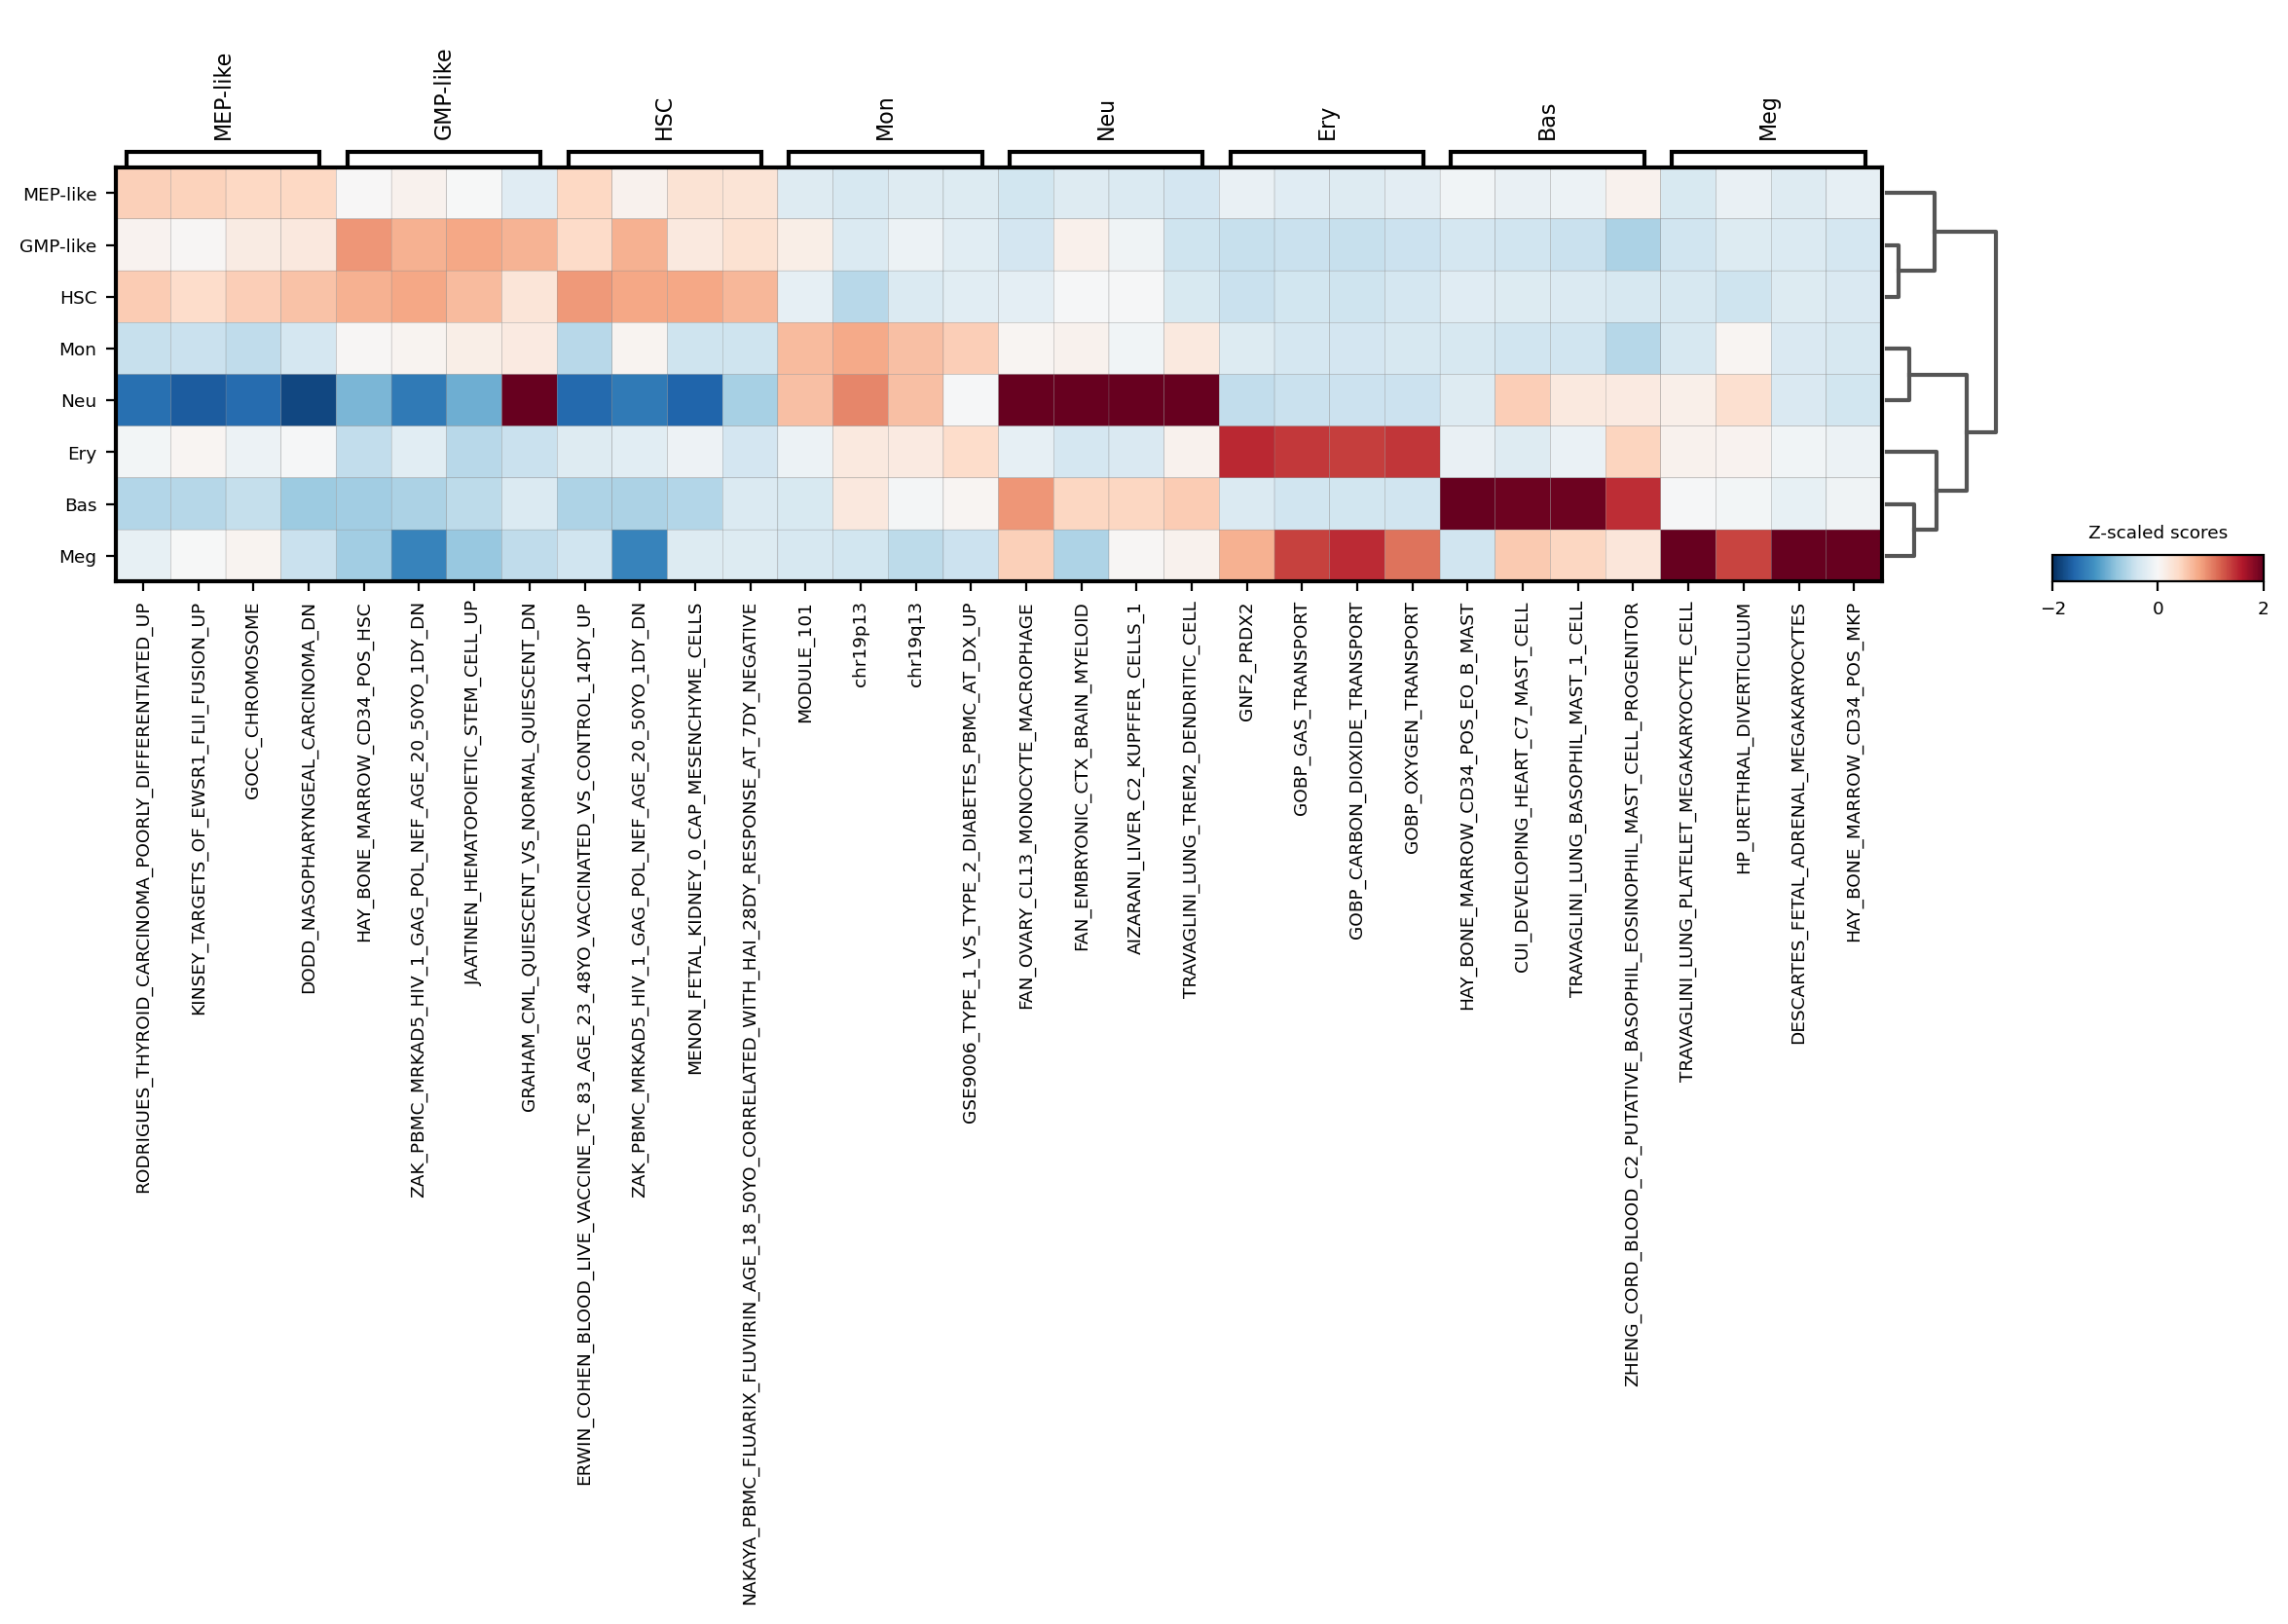

In [20]:
sc.pl.matrixplot(noFilter_Functional_acts, 
                 noFilter_source_markers1, 
                 'cell_type', 
                 dendrogram=True,
                 colorbar_title='Z-scaled scores', 
                 vmin=-2, 
                 vmax=2, 
                 cmap='RdBu_r',)